In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 294 ms (started: 2022-09-12 22:08:24 -07:00)


In the `olivetti.ipynb` note I noted that the original [ORL database website](https://cam-orl.co.uk/facedatabase.html) said the images were at a resolution of 92 x 112, but the versions you get from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html) are only 64 x 64. Unfortunately, the ORL website links to a defunct FTP site for the original files. However, the Wayback Machine has these files. We have two choices, a Z-compressed `tar` file (e.g. <https://web.archive.org/web/20160404224444/http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z>) or a `zip` file (e.g. <https://web.archive.org/web/20180728235255/http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip>). It's easier to work with the `zip` file, so we'll go with that.

These images are also out there on github if you look hard enough. For example <https://github.com/mohamed-elsayed-mohamed/Face-Recognition/tree/master/Datasets/att_faces> has them, but nested under various directories.

## Read the zip file

In [2]:
import zipfile
from io import BytesIO

import requests

url = "https://web.archive.org/web/20180728235255/http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip"
req = requests.get(url, timeout=10)
faces_zip = zipfile.ZipFile(BytesIO(req.content))

time: 926 ms (started: 2022-09-12 22:08:24 -07:00)


In [3]:
faces_zip.infolist()[:10]

[<ZipInfo filename='README' compress_type=deflate filemode='-rw-rw-rw-' file_size=1579 compress_size=840>,
 <ZipInfo filename='s1/' filemode='drwxrwxrwx' external_attr=0x10>,
 <ZipInfo filename='s1/6.pgm' compress_type=deflate filemode='-rw-rw-rw-' file_size=10318 compress_size=8590>,
 <ZipInfo filename='s1/7.pgm' compress_type=deflate filemode='-rw-rw-rw-' file_size=10318 compress_size=8927>,
 <ZipInfo filename='s1/8.pgm' compress_type=deflate filemode='-rw-rw-rw-' file_size=10318 compress_size=9255>,
 <ZipInfo filename='s1/9.pgm' compress_type=deflate filemode='-rw-rw-rw-' file_size=10318 compress_size=9289>,
 <ZipInfo filename='s1/10.pgm' compress_type=deflate filemode='-rw-rw-rw-' file_size=10318 compress_size=9341>,
 <ZipInfo filename='s1/1.pgm' compress_type=deflate filemode='-rw-rw-rw-' file_size=10318 compress_size=8939>,
 <ZipInfo filename='s1/2.pgm' compress_type=deflate filemode='-rw-rw-rw-' file_size=10318 compress_size=8508>,
 <ZipInfo filename='s1/3.pgm' compress_type=def

time: 41.4 ms (started: 2022-09-12 22:08:25 -07:00)


We are only interested in the image (`.pgm`) files:

In [4]:
zip_infos = [
    zip_info
    for zip_info in faces_zip.infolist()
    if not zip_info.is_dir() and zip_info.filename.endswith(".pgm")
]

time: 11.7 ms (started: 2022-09-12 22:08:25 -07:00)


Before reading the files, create a numpy `ndarray` that can store the image data:

In [5]:
n_subjects = 40
n_poses = 10
nx = 92
ny = 112
n_features = nx * ny
img_data = np.empty([n_subjects * n_poses, n_features], dtype=int)
img_data.shape

(400, 10304)

time: 20.3 ms (started: 2022-09-12 22:08:25 -07:00)


Now iterate over the images, read them into PIL, and then export the data as integers into the right row of `img_data`:

In [6]:
import PIL.Image

for zip_info in zip_infos:
    pgm_dir, pgm_filename = zip_info.filename.split("/")
    # s1/10.pgm => subject 1, pose 10, then zero-index to 0, 9
    subject_id = int(pgm_dir[1:])  # remove leading 2
    pose_id = int(pgm_filename[0:-4])  # strip trailing '.pgm'
    # then convert to 1D row index of output data
    idx = (subject_id - 1) * n_poses + (pose_id - 1)
    with faces_zip.open(zip_info.filename) as pgm_file:
        # PIL knows how to read these files
        img = PIL.Image.open(pgm_file)
        img_data[idx, :] = list(img.getdata())

time: 479 ms (started: 2022-09-12 22:08:26 -07:00)


In [7]:
img_data

array([[ 48,  49,  45, ...,  47,  46,  46],
       [ 60,  60,  62, ...,  32,  34,  34],
       [ 39,  44,  53, ...,  29,  26,  29],
       ...,
       [125, 119, 124, ...,  36,  39,  40],
       [119, 120, 120, ...,  89,  94,  85],
       [125, 124, 124, ...,  36,  35,  34]])

time: 6.3 ms (started: 2022-09-12 22:08:26 -07:00)


And don't forget to close the zip file:

In [8]:
faces_zip.close()

time: 2.65 ms (started: 2022-09-12 22:08:26 -07:00)


## View face image

In [25]:
import matplotlib.pyplot as plt


def show_olivetti92x112(olivetti92x112, subject, pose):
    if not 0 <= subject < 40:
        raise ValueError("subject should be a value in [0, 39]")
    n_poses = 10
    if not 0 <= pose < n_poses:
        raise ValueError("pose should be a value in [0, 9]")
    idx = subject * n_poses + pose
    nx = 92
    ny = 112
    if olivetti92x112.shape[1] != nx * ny:
        raise ValueError(f"olivetti image should be {nx} x {ny}")
    plt.imshow(
        olivetti92x112[idx].reshape((ny, nx)),
        cmap=plt.cm.gray,
        interpolation="nearest",
        vmin=0,
        vmax=255,
    )

time: 5.77 ms (started: 2022-09-12 23:05:48 -07:00)


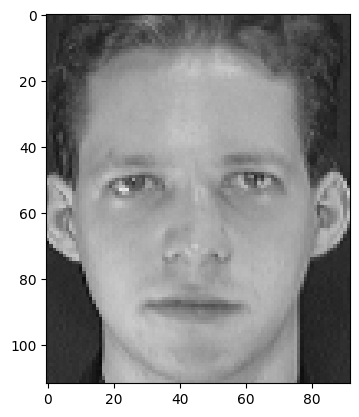

time: 101 ms (started: 2022-09-12 23:05:48 -07:00)


In [26]:
show_olivetti92x112(img_data, 0, 0)

If you compare these images to those in the `olivetti.ipynb` notebook, I don't think these are higher-res, but the 64x64 versions have been cropped to focus more on the face and to have less background shown.

## Pipeline

In [24]:
from drnb.util import categorize

target = pd.DataFrame(
    dict(
        pose_id=list(range(n_poses)) * n_subjects,
        subject_id=np.repeat(range(n_subjects), n_poses),
    )
)
categorize(target, "subject_id")

time: 6.26 ms (started: 2022-09-12 23:05:15 -07:00)


In [20]:
target

,pose_id,subject_id
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
395,5,39
396,6,39
397,7,39
398,8,39


time: 10.2 ms (started: 2022-09-12 22:14:11 -07:00)


In [21]:
from drnb.dataset import create_data_pipeline

data_pipe = create_data_pipeline(
    data_export=["csv", "npy"],
    target_export=["csv", "pkl"],
    neighbors=dict(
        n_neighbors=[15, 50, 150],
        method="exact",
        metric=["euclidean"],
        file_types=["csv", "npy"],
    ),
    triplets=dict(
        n_triplets_per_point=5,
        seed=1337,
        file_types=["csv", "npy"],
    ),
    verbose=True,
)

INFO:rich:Requesting one extra neighbor to account for self-neighbor


time: 10.9 ms (started: 2022-09-12 22:15:03 -07:00)


In [23]:
data_result = data_pipe.run(
    "olivetti92x112", data=img_data, target=target, verbose=True
)

INFO:rich:initial data shape: (400, 10304)
INFO:rich:Removing rows with NAs
INFO:rich:data shape after filtering NAs: (400, 10304)
INFO:rich:Keeping all columns
INFO:rich:data shape after filtering columns: (400, 10304)
INFO:rich:No scaling
INFO:rich:Converting to numpy with {'dtype': 'float32', 'layout': 'c'}
INFO:rich:Writing data for olivetti92x112
INFO:rich:Processing target with initial shape (400, 2)
INFO:rich:Keeping all columns
INFO:rich:Writing target for olivetti92x112
INFO:rich:Calculating nearest neighbors
INFO:rich:Finding 151 neighbors using faiss with euclidean metric and params: {}
INFO:rich:Calculating triplets
INFO:rich:Writing csv format to triplets/olivetti92x112.5.1337.idx.csv
INFO:rich:Writing csv format to triplets/olivetti92x112.5.1337.l2.csv
INFO:rich:Writing numpy format to triplets/olivetti92x112.5.1337.idx.npy
INFO:rich:Writing numpy format to triplets/olivetti92x112.5.1337.l2.npy
INFO:rich:Writing pipeline result for olivetti92x112


time: 2.6 s (started: 2022-09-12 22:15:36 -07:00)
